In [2]:
from dataclasses import dataclass

from archive.LBM_MS_Python_CuPy.functions import *

from tqdm import tqdm

Using cupy


In [3]:
ny_set = 670 #670
nx_set = int(ny_set * 2.5)
@dataclass
class Config:
    nx: int = nx_set
    ny: int = ny_set
    steps: int = 50000
    output_stride: int = 500
    molecular_weights: tuple[float, float, float] = (1, 1)
    pressure_frac: tuple[float, float, float] = (0.5, 0.5)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 9

    vx = 0.15

In [4]:
def initialise_chamber(config: Config, absorption_coefficient, ini_slope):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float32)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float32)
    pressure = xp.array(config.pressure_frac, dtype=xp.float32) * config.total_pressure
    for s in range(species):
        psigma[s, :, :] = pressure[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float32)
    ux_s = xp.ones((species, nx, ny), dtype=xp.float32) * config.vx
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float32)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

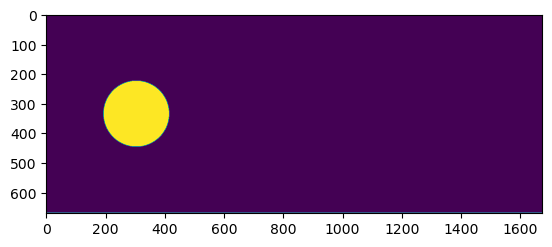

In [5]:
nx = Config.nx
ny = Config.ny
X, Y = np.meshgrid(range(nx), range(ny))

R = ny//6

cylinder = ((X-(nx/5.5))**2 + (Y-(ny/2))**2) < R**2
cylinder = cylinder.T

cylinder[:, :1] = True
cylinder[:, -1:] = True

plt.imshow(cylinder.T)

In [6]:
nb_table = np.array([0.50,0.60,0.72,0.87,1.05,1.26,1.51,1.82,2.19,2.63,3.16,3.80,4.57,5.49,6.61,7.95,9.56,11.5,13.8,16.6,], dtype = np.float32)
predict_lambda = 10 * nb_table[Config.nB] * (1/Config.molecular_weights[0]/3) * 1/np.sqrt(1/Config.molecular_weights[0] + 1/Config.molecular_weights[0])
print('lambda = ',predict_lambda)

relaxation = predict_lambda/(1+predict_lambda/2)
print('relaxation = ',relaxation)

viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

Re = 2*R * Config.vx / viscosity_kinematic
print('Re = ',Re)

lambda =  6.198969718141896
relaxation =  1.5121338244305034
viscosity_kinematic =  0.05377237645762337
Re =  619.2770748423751


In [7]:
re = []
rel = []
for i in range(len(nb_table)):
    print(i)
    multiplier = nb_table[i]
    print('nB = ',multiplier)
    predict_lambda = 10 * nb_table[i] * (1/Config.molecular_weights[0]/3) * 1/np.sqrt(1/Config.molecular_weights[0] + 1/Config.molecular_weights[0])
    print('lambda = ',predict_lambda)

    relaxation = predict_lambda/(1+predict_lambda/2)
    rel.append(relaxation)
    print('relaxation = ',relaxation)

    viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
    print('viscosity_kinematic = ',viscosity_kinematic)

    Re = 2*R * Config.vx / viscosity_kinematic
    print('Re = ',Re)
    re.append(Re)

0
nB =  0.5
lambda =  1.178511301977579
relaxation =  0.7415492285613978
viscosity_kinematic =  0.282842712474619
Re =  117.73327906756015
1
nB =  0.6
lambda =  1.4142136185688927
relaxation =  0.828427144029539
viscosity_kinematic =  0.2357022510295499
Re =  141.2799404950324
2
nB =  0.72
lambda =  1.6970563422826717
relaxation =  0.9180581441909317
viscosity_kinematic =  0.1964185425246249
Re =  169.5359285940389
3
nB =  0.87
lambda =  2.050609676680147
relaxation =  1.0124943355987899
viscosity_kinematic =  0.1625532821404541
Re =  204.8559067003467
4
nB =  1.05
lambda =  2.47487362176132
relaxation =  1.1061200073789812
viscosity_kinematic =  0.13468701205684452
Re =  247.23987481395582
5
nB =  1.26
lambda =  2.96984845850518
relaxation =  1.1951464851700708
viscosity_kinematic =  0.11223917246643307
Re =  296.68786100466747
6
nB =  1.51
lambda =  3.55910410949397
relaxation =  1.2804595990262702
viscosity_kinematic =  0.09365652790098529
Re =  355.5545005384475
7
nB =  1.82
lambda

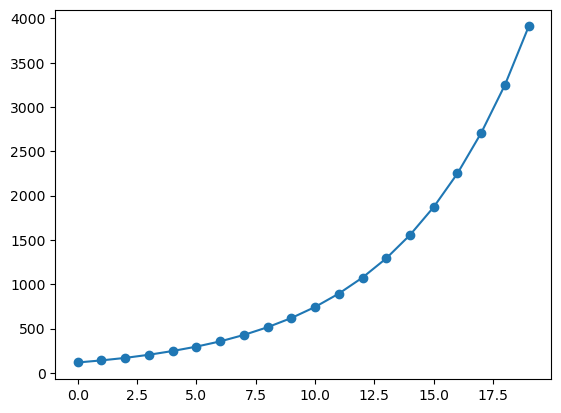

In [8]:
plt.plot(re, marker='o')

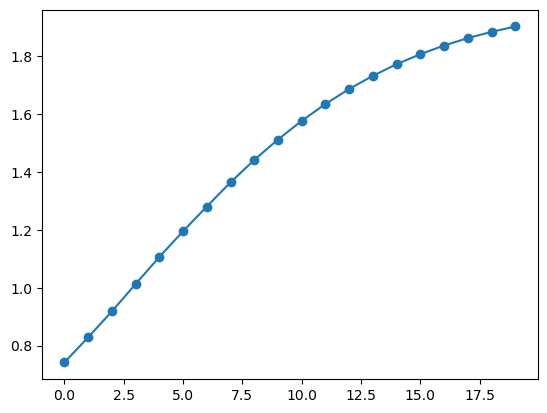

In [9]:
plt.plot(rel, marker='o')

In [10]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope, Config):
    cfg = Config()

    f, phi = initialise_chamber(cfg, absorption_coefficient, ini_slope)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float32)

    velocity_field = []
    for step in tqdm(range(cfg.steps + 1)):
        #f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 0.15, skip = 25, shapes=cylinder)
        if step % 500 == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            np.save(f"flow_field_nB{Config.nB}", np.array(velocity_field))
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_flow_object_inlet_outlet, step,
                     non_absorb_mask, bc_top, bc_bottom, inlet_vx= cfg.vx)

    return f

In [11]:
absorption_coefficient = 100
bc_top = None
bc_bottom = None
non_absorb_mask = None

In [12]:
f= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

100%|█████████▉| 50000/50001 [24:40<00:00, 33.76it/s]  


In [8]:
from joblib import Parallel, delayed

def _single_run(nb):
    @dataclass
    class Config:
        nx: int = 1675
        ny: int = 670
        steps: int = 70000
        output_stride: int = 5000
        molecular_weights: tuple[float, float, float] = (1, 1)
        pressure_frac: tuple[float, float, float] = (0.5, 0.5)
        total_pressure: float = 1.0
        theta: float = 0.5
        nB: int = nb

        vx = 0.15

    f= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

    return Config.nB

def nb_sweep():
    nbs = np.arange(20)

    results = Parallel(n_jobs = 2, backend='loky')(
        delayed(_single_run)(nb)
        for nb in nbs
    )
    return nbs, results

In [9]:
nbs, results = nb_sweep()